# How to train and deploy Learning To Rank

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/afoucret/elasticsearch-labs/blob/ltr-notebook/notebooks/learning-to-rank/01-learning-to-rank.ipynb)

In this notebook we will see example on how to train a Learning To Rank model using [XGBoost](https://xgboost.ai/) and how to deploy it to be used as a rescorer in Elasticsearch.

## Install required packages

First we will be installing packages required for our example.

In [177]:
# TODO: when eland 8.12.1 is released, we can avoid installing from github main:
!pip install git+https://github.com/elastic/eland@main
!pip install elasticsearch "eland[scikit-learn]" xgboost tqdm

  Cloning https://github.com/elastic/eland (to revision main) to /private/var/folders/g_/zb4vtmp57f1f1bjvhrg0v3qc0000gn/T/pip-req-build-c5201jfw
  Running command git clone -q https://github.com/elastic/eland /private/var/folders/g_/zb4vtmp57f1f1bjvhrg0v3qc0000gn/T/pip-req-build-c5201jfw
  Resolved https://github.com/elastic/eland to commit 2a6a4b1f06b39e79a3c67a450193992bf6c0ac0a
You should consider upgrading via the '/Users/afoucret/git/elasticsearch-labs/.venv/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/afoucret/git/elasticsearch-labs/.venv/bin/python3 -m pip install --upgrade pip' command.


## Configure your Elasticsearch deployment

For this example, we will be using an [Elastic Cloud](https://www.elastic.co/guide/en/cloud/current/ec-getting-started.html) deployment (available with a [free trial](https://cloud.elastic.co/registration?utm_source=github&utm_content=elasticsearch-labs-notebook)).

In [178]:
import getpass
from elasticsearch import Elasticsearch

# # Found in the "Manage Deployment" page
# try: CLOUD_ID
# except NameError: CLOUD_ID = getpass.getpass("Enter Elastic Cloud ID: ")

# # Password for the "elastic" user generated by Elasticsearch
# try: ELASTIC_PASSWORD
# except NameError:
#     ELASTIC_PASSWORD = getpass.getpass("Enter Elastic password: ")

# # Create the client instance
# es_client = Elasticsearch(
#     cloud_id=CLOUD_ID,
#     basic_auth=("elastic", ELASTIC_PASSWORD)
# )

es_client = Elasticsearch(hosts="http://localhost:9200", basic_auth=("elastic-admin", "elastic-password"))

client_info = es_client.info()

f"Successfully connected to cluster {client_info['cluster_name']} (version {client_info['version']['number']})"

'Successfully connected to cluster runTask (version 8.13.0-SNAPSHOT)'

## Configuring the dataset

In this example notebook we will use a dataset derived from [MSRD](https://github.com/metarank/msrd/tree/master) (Movie Search Ranking Dataset).

The dataset is available [here](https://github.com/elastic/elasticsearch-labs/tree/main//ltr-notebook/notebooks/learning-to-rank/sample_data/) and contains the following files:

- **movies_corpus.jsonl.gz**
- **movies_judgements.csv.gz**:
- **movies_index_settings.json**

In [179]:
from urllib.parse import urljoin

# TODO: use elastic/elasticsearch-labs instead of afoucret/elasticsearch-labs before merging the PR.

DATASET_BASE_URL = "https://raw.githubusercontent.com/afoucret/elasticsearch-labs/ltr-notebook/notebooks/learning-to-rank/sample_data/"

CORPUS_URL = urljoin(DATASET_BASE_URL, "movies_corpus.jsonl.gz")
JUDGEMENTS_FILE_URL = urljoin(DATASET_BASE_URL,"movies_judgments.csv.gz")
INDEX_SETTINGS_URL = urljoin(DATASET_BASE_URL,"movies_index_settings.json")


 ## Importing the document corpus

This step will import the documents of the corpus into the `movies` index .

Documments contains the following fields:

| Field name   | Description                                 |
|--------------|---------------------------------------------|
| `id`         | Id of the document                          |
| `title`      | Movie title                                 |
| `overview`   | A short description of the movie            |
| `actors`     | List of actors in the movies                |
| `director`   | Director of the movie                       |
| `characters` | List of characters that appear in the movie |
| `genres`     | Genres of the movie                         |
| `year`       | Year the movie was released                 |
| `budget`     | Budget of the movies in USD                 |
| `votes`      | Number of votes received by the movie       |
| `rating`     | Average rating of the movie                 |
| `popularity` | Number use to measure the movie popularity  |
| `tags`       | A list of tags for the movies               |



In [180]:
import json
import elasticsearch.helpers as es_helpers
import pandas as pd
from urllib.request import urlopen

MOVIE_INDEX = "movies"

# Delete index
print("Deleting index if it already exists:", MOVIE_INDEX)
es_client.options(ignore_status=[400, 404]).indices.delete(index=MOVIE_INDEX)

print("Creating index:", MOVIE_INDEX)
index_settings = json.load(urlopen(INDEX_SETTINGS_URL))
es_client.indices.create(index=MOVIE_INDEX, **index_settings)

print(f"Loading the corpus from {CORPUS_URL}")
corpus_df = pd.read_json(CORPUS_URL, lines=True)

print(f"Indexing the corpus into {MOVIE_INDEX} ...")
bulk_result = es_helpers.bulk(
  es_client,
  actions=[{ "_id": movie['id'], "_index": MOVIE_INDEX, **movie } for movie in corpus_df.to_dict('records')]
)
print(f"Indexed {bulk_result[0]} documents into {MOVIE_INDEX}")

Deleting index if it already exists: movies
Creating index: movies
Loading the corpus from https://raw.githubusercontent.com/afoucret/elasticsearch-labs/ltr-notebook/notebooks/learning-to-rank/sample_data/movies_corpus.jsonl.gz
Indexing the corpus into movies ...
Indexed 9751 documents into movies


## Loading the judgment list

Judgemnent list provides human judgement that will be used to train our Learning To Rank model.

Each row represents a query-document pair with an associated relevance grade and conatisn the following columns:

- `query_id`: Pair for the same queries are group together and received a unique id.
- `query`: Actual text for the query
- `doc_id` Id of the document
- `grade` The relevance grade can be binary value (relevant or not relavant) like in our example or a number that represent the degree of relevance (e.g. from `0` to `4`)

In [184]:
judgments_df  = pd.read_csv(JUDGEMENTS_FILE_URL, delimiter="\t")
judgments_df

,query_id,query,doc_id,grade
0,qid:5141,insidious 2 netflix,846433,0
1,qid:5141,insidious 2 netflix,49018,1
2,qid:5141,insidious 2 netflix,38234,0
3,qid:5141,insidious 2 netflix,567604,0
4,qid:5141,insidious 2 netflix,269795,0
...,...,...,...,...
384750,qid:3383,2013 the wolverine,263115,0
384751,qid:3383,2013 the wolverine,25913,0
384752,qid:3383,2013 the wolverine,567604,0
384753,qid:3383,2013 the wolverine,533535,0


## Configure feature extraction

Features are the input data of our model. They represents the document in the context of the query.
For LTR, we are using templated queries to extract features.
Eland proposes an API to define the feature extraction has shown bellow.

In [185]:
from eland.ml.ltr import LTRModelConfig, QueryFeatureExtractor

ltr_config = LTRModelConfig(
  feature_extractors = [
      # For the following field we want to use the score of the match query for the field as a features:
      QueryFeatureExtractor(
        feature_name="title_bm25",
        query={ "match": { "title": "{{query}}" } }
      ),
      QueryFeatureExtractor(
        feature_name="actors_bm25",
        query={ "match": { "actors": "{{query}}" } }
      ),
      QueryFeatureExtractor(
        feature_name="director_bm25",
        query={ "match": { "director": "{{query}}" } }
      ),
      QueryFeatureExtractor(
        feature_name="overview_bm25",
        query={ "match": { "overview": "{{query}}" } }
      ),
      QueryFeatureExtractor(
        feature_name="characters_bm25",
        query={ "match": { "characters": "{{query}}" } }
      ),
      QueryFeatureExtractor(
        feature_name="tags_bm25",
        query={ "match": { "tags": "{{query}}" } }
      ),
      # We could also use a more strict matching clause as an additional features. Here we want all the terms of our query to match.
      QueryFeatureExtractor(
        feature_name="title_all_terms_bm25",
        query={ "match": { "title": { "query": "{{query}}", "minimum_should_match": "100%" } } }
      ),
      QueryFeatureExtractor(
        feature_name="actors_all_terms_bm25",
        query={ "match": { "actors": { "query": "{{query}}", "minimum_should_match": "100%" } } }
      ),
      QueryFeatureExtractor(
        feature_name="director_all_terms_bm25",
        query={ "match": { "director": { "query": "{{query}}", "minimum_should_match": "100%" } } }
      ),
      # Also we can use a script_score query to get the document field values directly as a feature.
      QueryFeatureExtractor(
        feature_name="popularity",
        query={
            "script_score": {
              "query": { "exists": { "field": "popularity" } },
              "script": { "source": "return doc['popularity'].value;" }
          }
        }
      ),
      QueryFeatureExtractor(
        feature_name="votes",
        query={
            "script_score": {
              "query": { "exists": { "field": "votes" } },
              "script": { "source": "return doc['votes'].value;" }
          }
        }
      ),
      QueryFeatureExtractor(
        feature_name="rating",
        query={
            "script_score": {
              "query": { "exists": { "field": "rating" } },
              "script": { "source": "return doc['rating'].value;" }
          }
        }
      ),
      QueryFeatureExtractor(
        feature_name="year",
        query={
            "script_score": {
              "query": { "exists": { "field": "year" } },
              "script": { "source": "return doc['year'].value;" }
          }
        }
      ),
      QueryFeatureExtractor(
        feature_name="budget",
        query={
            "script_score": {
              "query": { "exists": { "field": "budget" } },
              "script": { "source": "return doc['budget'].value;" }
          }
        }
      )
  ]
)

## Adding features to the judgement list

During this step we will add features to our judgmennt list. The resuling dataframe will be used to train our model.

**Note** This operation is quite fast if your Elasticsearch instance is local or close (around 1 min 30 sec.) but can be much longer if it is not the case (more than 10 minutes). When using Google Collab it is difficult to control where your notebook is executed and it is likely that you can get in the later case.

In [188]:
import numpy
from tqdm import tqdm

from eland.ml.ltr import FeatureLogger

features_logger = FeatureLogger(es_client, MOVIE_INDEX, ltr_config)

def judgment_dataframe_with_features(judgments_df, feature_logger, query_id_column:str='query_id', doc_id_column:str = 'doc_id', query_params_columns = ['query']):
    tqdm.pandas()
    feature_names = features_logger._model_config.feature_names
    def _extract_query_features(query_judgements_group):
        doc_ids = query_judgements_group[doc_id_column].to_list()
        query_params = { param_name: query_judgements_group[param_name].iloc[0] for param_name in query_params_columns }
        doc_features =  feature_logger.extract_features(query_params, doc_ids)
        for feature_index, feature_name in enumerate(feature_names):
            query_judgements_group[feature_name] = numpy.array([doc_features[doc_id][feature_index] for doc_id in doc_ids])
        return query_judgements_group

    judgments_with_features = judgments_df.astype('str').groupby(query_id_column, group_keys=False).progress_apply(_extract_query_features)
    return judgments_with_features

judgments_with_features = judgment_dataframe_with_features(judgments_df, features_logger)

judgments_with_features

100%|██████████| 16279/16279 [01:38<00:00, 165.01it/s]


,query_id,query,doc_id,grade,title_bm25,actors_bm25,director_bm25,overview_bm25,characters_bm25,tags_bm25,title_all_terms_bm25,actors_all_terms_bm25,director_all_terms_bm25,popularity,votes,rating,year,budget
0,qid:5141,insidious 2 netflix,846433,0,NaN,9.555378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.628,26.0,5.900,2022.0,0.0
1,qid:5141,insidious 2 netflix,49018,1,10.339964,NaN,NaN,NaN,3.001572,NaN,NaN,NaN,NaN,64.003,5762.0,6.934,2010.0,1500000.0
2,qid:5141,insidious 2 netflix,38234,0,NaN,NaN,NaN,4.408295,3.325243,NaN,NaN,NaN,NaN,143.211,682.0,7.575,2010.0,3000000.0
3,qid:5141,insidious 2 netflix,567604,0,NaN,NaN,NaN,6.747458,2.889085,NaN,NaN,NaN,NaN,32.913,599.0,7.125,2018.0,0.0
4,qid:5141,insidious 2 netflix,269795,0,4.124997,NaN,NaN,6.888034,NaN,NaN,NaN,NaN,NaN,21.058,1298.0,5.968,2017.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384750,qid:3383,2013 the wolverine,263115,0,NaN,NaN,NaN,0.284286,6.354955,6.741876,NaN,NaN,NaN,68.287,17280.0,7.814,2017.0,97000000.0
384751,qid:3383,2013 the wolverine,25913,0,NaN,NaN,NaN,NaN,7.825152,NaN,NaN,NaN,NaN,21.026,454.0,6.237,2002.0,0.0
384752,qid:3383,2013 the wolverine,567604,0,NaN,NaN,NaN,NaN,5.759561,NaN,NaN,NaN,NaN,32.913,599.0,7.125,2018.0,0.0
384753,qid:3383,2013 the wolverine,533535,0,NaN,NaN,NaN,0.318215,8.011290,NaN,NaN,NaN,NaN,34.773,0.0,0.000,2024.0,0.0


In [189]:
# This step will separate the dataset in two different parts one used for the training and one used for the evaluation of the model.

import random

def test_train_split(df, eval_ratio=0.3, group_field='query_id'):
  def _add_split(query_judgements_group):
    split,  = random.choices(['train', 'eval'], [1 - eval_ratio, eval_ratio])
    query_judgements_group['split'] = split
    return query_judgements_group
  df_with_split = df.groupby(group_field, group_keys=False).apply(_add_split)
  return (
    df_with_split.query('split == "train"').drop(columns='split'),
    df_with_split.query('split == "eval"').drop(columns='split')
  )

train_judgments_df, eval_judgments_df = test_train_split(judgments_with_features)

## Create and train the model

TODO describe XGBRanker model.

In [190]:
import xgboost as xgb

# Create the ranker model:

ranker = xgb.XGBRanker(
  tree_method="hist",
  booster="gbtree",
  n_estimators=200,
  objective="rank:ndcg",
  eval_metric=["ndcg@10"],
  early_stopping_rounds=20,
)

# Shaping training and eval data in the expected format.
train_query_groups = train_judgments_df['query_id'].value_counts().sort_index().values
train_target = train_judgments_df['grade'].values
train_features = train_judgments_df[ltr_config.feature_names]

eval_query_groups = eval_judgments_df['query_id'].value_counts().sort_index().values
eval_target = eval_judgments_df['grade'].values
eval_features = eval_judgments_df[ltr_config.feature_names]

# Training the model
ranker.fit(
  X=train_features,
  y=train_target,
  group=train_query_groups,
  eval_set=[(eval_features, eval_target)],
  eval_group=[eval_query_groups],
  verbose=True
)

[0]	validation_0-ndcg@10:0.87325
[1]	validation_0-ndcg@10:0.88022
[2]	validation_0-ndcg@10:0.88400
[3]	validation_0-ndcg@10:0.88651
[4]	validation_0-ndcg@10:0.88714
[5]	validation_0-ndcg@10:0.88779
[6]	validation_0-ndcg@10:0.88996
[7]	validation_0-ndcg@10:0.89021
[8]	validation_0-ndcg@10:0.89071
[9]	validation_0-ndcg@10:0.89107
[10]	validation_0-ndcg@10:0.89166
[11]	validation_0-ndcg@10:0.89223
[12]	validation_0-ndcg@10:0.89271
[13]	validation_0-ndcg@10:0.89331
[14]	validation_0-ndcg@10:0.89405
[15]	validation_0-ndcg@10:0.89459
[16]	validation_0-ndcg@10:0.89432
[17]	validation_0-ndcg@10:0.89476
[18]	validation_0-ndcg@10:0.89517
[19]	validation_0-ndcg@10:0.89580
[20]	validation_0-ndcg@10:0.89581
[21]	validation_0-ndcg@10:0.89620
[22]	validation_0-ndcg@10:0.89632
[23]	validation_0-ndcg@10:0.89641
[24]	validation_0-ndcg@10:0.89699
[25]	validation_0-ndcg@10:0.89702
[26]	validation_0-ndcg@10:0.89722
[27]	validation_0-ndcg@10:0.89766
[28]	validation_0-ndcg@10:0.89776
[29]	validation_0-ndcg@1

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=20, enable_categorical=False,
          eval_metric=['ndcg@10'], feature_types=None, gamma=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=200,
          n_jobs=None, num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

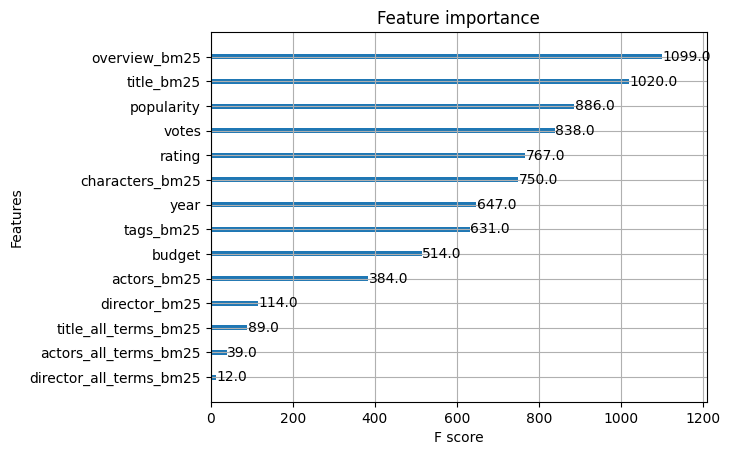

In [191]:
xgb.plot_importance(ranker, importance_type='weight')


In [ ]:
## Importing the model to Elasticsearch

TODO: describe model import

In [166]:
from eland.ml import MLModel

MLModel.import_ltr_model(
  es_client=es_client,
  model=ranker,
  model_id='ltr-model-xgboost',
  ltr_model_config=ltr_config,
  es_if_exists = 'replace'
)

## Using the rescorer

TODO: small description

In [194]:
query = 'star wars'

# First let's display the result when not using the rescorer:
[
  (movie['_source']['title'], movie['_score'],  movie['_id']) for movie in es_client.search(
    index=MOVIE_INDEX,
    query={ "multi_match": { "query": query, "type": "best_fields", "fields": ["title", "overview", "actors", "director"] } }
  )['hits']['hits']
]

[('Andor: A Disney+ Day Special Look', 13.56216, '1022100'),
 ("Family Guy Presents: It's a Trap!", 13.124658, '278427'),
 ('Star Wars', 13.0546055, '11'),
 ('Star Wars: The Clone Wars', 12.029154, '12180'),
 ('Maggie Simpson in The Force Awakens from Its Nap', 10.004788, '825597'),
 ('Star Wars: The Force Awakens', 8.913883, '140607'),
 ('Star Wars: The Last Jedi', 8.913883, '181808'),
 ('LEGO Star Wars Terrifying Tales', 8.913883, '857702'),
 ('LEGO Star Wars Summer Vacation', 8.913883, '980804'),
 ('Solo: A Star Wars Story', 8.913883, '348350')]

In [195]:
# Now let's display result using the rescorer:
[
  (movie['_source']['title'], movie['_score'], movie['_id']) for movie in es_client.search(
    index=MOVIE_INDEX,
    query={ "multi_match": { "query": query, "type": "best_fields", "fields": ["title", "overview", "actors", "director"] } },
    rescore={ "learning_to_rank": { "model_id": "ltr-model-xgboost", "params": {"query": query} }, "window_size": 100 }
  )['hits']['hits']
]

[('Star Wars', 3.1619391, '11'),
 ('Star Wars: The Force Awakens', 2.6710274, '140607'),
 ('Star Wars: The Last Jedi', 2.6690176, '181808'),
 ('Star Wars: Episode I - The Phantom Menace', 2.619148, '1893'),
 ('Star Wars: The Clone Wars', 2.5880697, '12180'),
 ('Star Wars: The Rise of Skywalker', 2.3001318, '181812'),
 ('LEGO Star Wars Holiday Special', 2.2947505, '732670'),
 ('Solo: A Star Wars Story', 2.1442964, '348350'),
 ('Star Wars: Episode II - Attack of the Clones', 1.3256439, '1894'),
 ('The Star Wars Holiday Special', 1.1956286, '74849')]